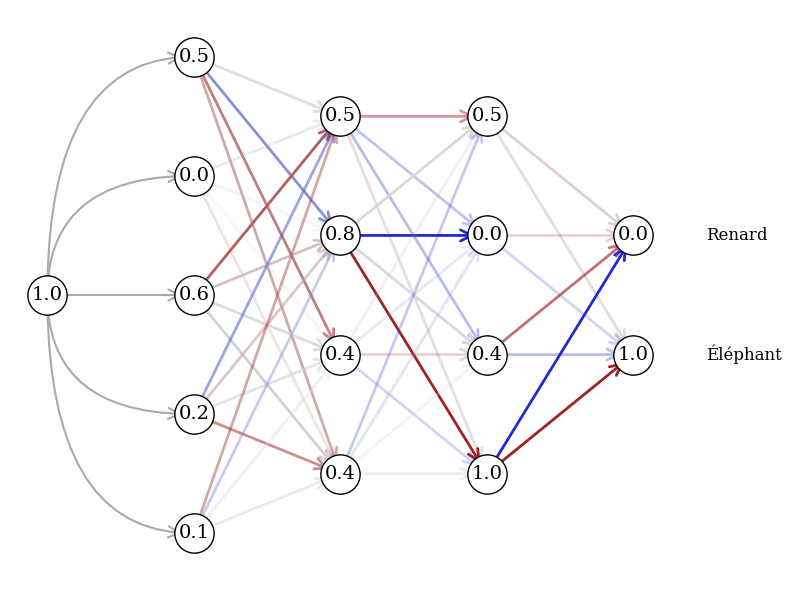

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

plt.rcParams["font.family"] = "serif"
# plt.rcParams['font.sans-serif'] = ['Garamond']


def relu(x):
    return max(0, x)


def he_initialization(fan_in):
    return np.random.normal(0, np.sqrt(2 / fan_in))


def normalize_dict_values(d):
    """Normalize values in a dictionary to [0,1] range"""
    values = np.array(list(d.values()))
    if np.max(values) - np.min(values) == 0:
        return d
    normalized = {
        k: (v - np.min(values)) / (np.max(values) - np.min(values))
        for k, v in d.items()
    }
    return normalized


def create_neural_network_visualization(
    layer_sizes=[1, 5, 4, 4, 2], title="Neural Network Architecture with Activations"
):
    G = nx.DiGraph()
    pos = {}
    node_activations = {}

    colors = ["#1f2bcf", "#dedede", "#9e2323"]
    n_bins = 100
    cmap = LinearSegmentedColormap.from_list("custom", colors, N=n_bins)

    y_spacing = 1.0
    x_spacing = 1.0

    activations_map = [0.5, 0.0, 0.6, 0.2, 0.1]

    # Initialize nodes and first layer activations
    for i, layer_size in enumerate(layer_sizes):
        for j in range(layer_size):
            node_id = f"L{i}_{j}"
            if i == 0:
                activation = 1.0
            elif i == 1:
                activation = activations_map[j]
            else:
                activation = 0.1

            G.add_node(node_id, activation=activation)
            node_activations[node_id] = activation

            y_pos = (layer_size - 1) * y_spacing / 2 - j * y_spacing
            pos[node_id] = (i * x_spacing, y_pos)

    # Add edges with He initialization for weights
    edge_weights = {}

    for i in range(len(layer_sizes) - 1):
        fan_in = layer_sizes[i]
        for node1 in [f"L{i}_{j}" for j in range(layer_sizes[i])]:
            for node2 in [f"L{i + 1}_{j}" for j in range(layer_sizes[i + 1])]:
                weight = he_initialization(fan_in)
                if node1 == "L3_3" and node2 == "L4_1":
                    weight = 1
                if node1 == "L3_3" and node2 == "L4_0":
                    weight = -1
                if node1 == "L3_1" and node2 == "L4_1":
                    weight = -1
                if node1 == "L3_1" and node2 == "L4_0":
                    weight = 1
                if node1 == "L0_0" and node2 == "L1_0":
                    weight = 1
                if node1 == "L2_1" and node2 == "L3_3":
                    weight = 1

                edge_weights[(node1, node2)] = weight

    # Propagate activations through the network
    for i in range(2, len(layer_sizes)):
        for j in range(layer_sizes[i]):
            current_node = f"L{i}_{j}"
            weighted_sum = 0.1
            for k in range(layer_sizes[i - 1]):
                prev_node = f"L{i - 1}_{k}"
                weight = edge_weights[(prev_node, current_node)]
                prev_activation = node_activations[prev_node]
                weighted_sum += weight * prev_activation

            activation = relu(weighted_sum)
            # Now put predefined values
            if current_node == "L3_3":
                activation = 1
            elif current_node == "L3_1":
                activation = 0
            elif current_node == "L2_1":
                activation = 0.8
            # elif i == len(layer_sizes) - 2:
            # activation = np.clip(activation, -0.3, 0.3)

            node_activations[current_node] = activation

    plt.figure(figsize=(8, 6))

    # Draw nodes
    layer_colors = ["white"] * len(layer_sizes)
    for i, layer_size in enumerate(layer_sizes):
        nodes = [f"L{i}_{j}" for j in range(layer_size)]
        nx.draw_networkx_nodes(
            G,
            pos,
            nodelist=nodes,
            node_color=layer_colors[i],
            edgecolors="black",
            node_size=800,
        )

        # Add activation values inside nodes
        for node in nodes:
            x, y = pos[node]
            plt.text(
                x,
                y,
                f"{node_activations[node]:.1f}",
                horizontalalignment="center",
                verticalalignment="center",
                color="black",
                # fontweight='bold',
                fontsize=14,
            )

    # Draw edges with normalized alpha per layer
    for i in range(len(layer_sizes) - 1):
        layer_edges = {
            (n1, n2): abs(node_activations[n1])
            for n1 in [f"L{i}_{j}" for j in range(layer_sizes[i])]
            for n2 in [f"L{i + 1}_{j}" for j in range(layer_sizes[i + 1])]
        }
        if i == 0:
            normalized_activations = layer_edges
        else:
            normalized_activations = normalize_dict_values(layer_edges)

        for (node1, node2), norm_activation in normalized_activations.items():
            alpha = min(1.0, max(0.2, np.sqrt(norm_activation)))
            width = 2.0
            weight = edge_weights[(node1, node2)]
            norm_weight = np.clip(weight, -1, 1)
            if i == 0:
                color = "#aaaaaa"
            else:
                color = cmap((norm_weight + 1) / 2)

            if i == 0:  # Curved connections from layer -1
                nx.draw_networkx_edges(
                    G,
                    pos,
                    edgelist=[(node1, node2)],
                    edge_color=[color],
                    alpha=alpha,
                    arrows=True,
                    arrowsize=20,
                    arrowstyle="->",
                    style="-",
                    width=1.5,
                    connectionstyle="angle3,angleA=90,angleB=0",
                )
            else:
                nx.draw_networkx_edges(
                    G,
                    pos,
                    edgelist=[(node1, node2)],
                    edge_color=[color],
                    alpha=alpha,
                    width=width,
                    arrows=True,
                    arrowsize=20,
                    arrowstyle="->",
                )

    # Add output labels
    output_labels = ["Renard", "Éléphant"]
    for j, label in enumerate(output_labels):
        x, y = pos[f"L{len(layer_sizes) - 1}_{j}"]
        plt.text(
            x + 0.5,
            y,
            label,
            horizontalalignment="left",
            verticalalignment="center",
            fontsize=12,
        )

    # Add black circle around highest output logit
    output_nodes = [f"L{len(layer_sizes) - 1}_{j}" for j in range(layer_sizes[-1])]
    output_values = [node_activations[node] for node in output_nodes]
    winner_idx = np.argmax(output_values)
    winner_pos = pos[output_nodes[winner_idx]]

    # # Add layer labels at the top
    # layer_names = ['Image',
    #               'Entrées\nValeur des pixels',
    #               'Couche de neurones 1\nBords',
    #               'Couche de neurones 2\nFormes simples',
    #               'Couche de neurones 3\nFormes complexes',
    #               'Sortie']

    # for i, name in enumerate(layer_names):
    #     plt.text(i*x_spacing, max(pos.values(), key=lambda x: x[1])[1] + y_spacing/2,
    #             name,
    #             horizontalalignment='center',
    #             fontsize=12,
    #             fontweight='bold')

    # plt.title(title, pad=40, size=14)
    plt.axis("off")
    return plt


nn_viz = create_neural_network_visualization()
nn_viz.tight_layout()
plt.savefig("reseau.png", dpi=500)
plt.show()